In [ ]:

#### utils.py 
from __future__ import division
import math
import json
import random
import pprint
import scipy.misc
import numpy as np
from time import gmtime, strftime
from six.moves import xrange
import matplotlib.pyplot as plt

pp = pprint.PrettyPrinter()

get_stddev = lambda x, k_h, k_w: 1/math.sqrt(k_w*k_h*x.get_shape()[-1])

def conv_out_size_same(size, stride):
  """Compute the conv layer output size.
  
  Arguments:
    size {int} -- Input size.
    stride {int} -- conv stride.
  
  Returns:
    [int] -- conv layer output size
  """

  return int(math.ceil(float(size) / float(stride)))
  
def get_image(image_path, input_height, input_width,
              resize_height=64, resize_width=64,
              crop=True, grayscale=False):
  image = imread(image_path, grayscale)
  return transform(image, input_height, input_width,
                   resize_height, resize_width, crop)

def get_image_Slicization(image_path, patch_size, patch_step, grayscale=False):
  image = imread(image_path, grayscale).astype(np.float32)
  tmpTransform , nSlicization_shape = transform_Slicization(image/127.5 -1, patch_size, patch_step)  #[100:235,0:360]
  return tmpTransform.reshape(-1,patch_size[0],patch_size[1],1)


def get_image_SlicizationWithShape(image_path, patch_size, patch_step, grayscale=False):
  image = imread(image_path, grayscale).astype(np.float32)
  tmpTransform , nSlicization_shape = transform_Slicization(image/127.5 -1., patch_size, patch_step)   #[100:230,0:360]
  return tmpTransform.reshape(-1,patch_size[0],patch_size[1],1), nSlicization_shape

def transform_Slicization(image, patch_size, patch_step):
  return kh_make_patches(image,patch_size,patch_step)

def save_images(images, size, image_path):
  return imsave(inverse_transform(images), size, image_path)

def imread(path, grayscale = False):
  if (grayscale):
    #print(path)
    return scipy.misc.imread(path, flatten = True).astype(np.float)
  else:
    return scipy.misc.imread(path).astype(np.float)

def merge_images(images, size):
  return inverse_transform(images)

def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  if (images.shape[3] in (3,4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    try:
      for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j * h:j * h + h, i * w:i * w + w, :] = image
      return img
    except:
      return img
  elif images.shape[3]==1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      #print(idx)
      a = img[j * h:j * h + h, i * w:i * w + w]
      if(a.shape == image[:, :, 0].shape):
        img[j * h:j * h + h, i * w:i * w + w] = image[:, :, 0]
    return img
  else:
    raise ValueError('in merge(images,size) images parameter '
                     'must have dimensions: HxW or HxWx3 or HxWx4')

def imsave(images, size, path):
  image = np.squeeze(merge(images, size))
  return scipy.misc.imsave(path, image)

def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
  if crop_w is None:
    crop_w = crop_h
  h, w = x.shape[:2]
  j = int(round((h - crop_h)/2.))
  i = int(round((w - crop_w)/2.))
  return scipy.misc.imresize(
      x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
  if crop:
    cropped_image = center_crop(
      image, input_height, input_width, 
      resize_height, resize_width)
  else:
    cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
  return np.array(cropped_image)/127.5 - 1.

def inverse_transform(images):
  return (images+1.)/2.

def to_json(output_path, *layers):
  with open(output_path, "w") as layer_f:
    lines = ""
    for w, b, bn in layers:
      layer_idx = w.name.split('/')[0].split('h')[1]

      B = b.eval()

      if "lin/" in w.name:
        W = w.eval()
        depth = W.shape[1]
      else:
        W = np.rollaxis(w.eval(), 2, 0)
        depth = W.shape[0]

      biases = {"sy": 1, "sx": 1, "depth": depth, "w": ['%.2f' % elem for elem in list(B)]}
      if bn != None:
        gamma = bn.gamma.eval()
        beta = bn.beta.eval()

        gamma = {"sy": 1, "sx": 1, "depth": depth, "w": ['%.2f' % elem for elem in list(gamma)]}
        beta = {"sy": 1, "sx": 1, "depth": depth, "w": ['%.2f' % elem for elem in list(beta)]}
      else:
        gamma = {"sy": 1, "sx": 1, "depth": 0, "w": []}
        beta = {"sy": 1, "sx": 1, "depth": 0, "w": []}

      if "lin/" in w.name:
        fs = []
        for w in W.T:
          fs.append({"sy": 1, "sx": 1, "depth": W.shape[0], "w": ['%.2f' % elem for elem in list(w)]})

        lines += """
          var layer_%s = {
            "layer_type": "fc", 
            "sy": 1, "sx": 1, 
            "out_sx": 1, "out_sy": 1,
            "stride": 1, "pad": 0,
            "out_depth": %s, "in_depth": %s,
            "biases": %s,
            "gamma": %s,
            "beta": %s,
            "filters": %s
          };""" % (layer_idx.split('_')[0], W.shape[1], W.shape[0], biases, gamma, beta, fs)
      else:
        fs = []
        for w_ in W:
          fs.append({"sy": 5, "sx": 5, "depth": W.shape[3], "w": ['%.2f' % elem for elem in list(w_.flatten())]})

        lines += """
          var layer_%s = {
            "layer_type": "deconv", 
            "sy": 5, "sx": 5,
            "out_sx": %s, "out_sy": %s,
            "stride": 2, "pad": 1,
            "out_depth": %s, "in_depth": %s,
            "biases": %s,
            "gamma": %s,
            "beta": %s,
            "filters": %s
          };""" % (layer_idx, 2**(int(layer_idx)+2), 2**(int(layer_idx)+2),
               W.shape[0], W.shape[3], biases, gamma, beta, fs)
    layer_f.write(" ".join(lines.replace("'","").split()))

def make_gif(images, fname, duration=2, true_image=False):
  import moviepy.editor as mpy

  def make_frame(t):
    try:
      x = images[int(len(images)/duration*t)]
    except:
      x = images[-1]

    if true_image:
      return x.astype(np.uint8)
    else:
      return ((x+1)/2*255).astype(np.uint8)

  clip = mpy.VideoClip(make_frame, duration=duration)
  clip.write_gif(fname, fps = len(images) / duration)

def visualize(sess, dcgan, config, option):
  image_frame_dim = int(math.ceil(config.batch_size**.5))
  if option == 0:
    z_sample = np.random.uniform(-0.5, 0.5, size=(config.batch_size, dcgan.z_dim))
    samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})
    save_images(samples, [image_frame_dim, image_frame_dim], './samples/test_%s.png' % strftime("%Y%m%d%H%M%S", gmtime()))
  elif option == 1:
    values = np.arange(0, 1, 1./config.batch_size)
    for idx in xrange(100):
      print(" [*] %d" % idx)
      z_sample = np.zeros([config.batch_size, dcgan.z_dim])
      for kdx, z in enumerate(z_sample):
        z[idx] = values[kdx]

      if config.dataset == "mnist":
        y = np.random.choice(10, config.batch_size)
        y_one_hot = np.zeros((config.batch_size, 10))
        y_one_hot[np.arange(config.batch_size), y] = 1

        samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
      else:
        samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})

      save_images(samples, [image_frame_dim, image_frame_dim], './samples/test_arange_%s.png' % (idx))
  elif option == 2:
    values = np.arange(0, 1, 1./config.batch_size)
    for idx in [random.randint(0, 99) for _ in xrange(100)]:
      print(" [*] %d" % idx)
      z = np.random.uniform(-0.2, 0.2, size=(dcgan.z_dim))
      z_sample = np.tile(z, (config.batch_size, 1))
      #z_sample = np.zeros([config.batch_size, dcgan.z_dim])
      for kdx, z in enumerate(z_sample):
        z[idx] = values[kdx]

      if config.dataset == "mnist":
        y = np.random.choice(10, config.batch_size)
        y_one_hot = np.zeros((config.batch_size, 10))
        y_one_hot[np.arange(config.batch_size), y] = 1

        samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample, dcgan.y: y_one_hot})
      else:
        samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})

      try:
        make_gif(samples, './samples/test_gif_%s.gif' % (idx))
      except:
        save_images(samples, [image_frame_dim, image_frame_dim], './samples/test_%s.png' % strftime("%Y%m%d%H%M%S", gmtime()))
  elif option == 3:
    values = np.arange(0, 1, 1./config.batch_size)
    for idx in xrange(100):
      print(" [*] %d" % idx)
      z_sample = np.zeros([config.batch_size, dcgan.z_dim])
      for kdx, z in enumerate(z_sample):
        z[idx] = values[kdx]

      samples = sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample})
      make_gif(samples, './samples/test_gif_%s.gif' % (idx))
  elif option == 4:
    image_set = []
    values = np.arange(0, 1, 1./config.batch_size)

    for idx in xrange(100):
      print(" [*] %d" % idx)
      z_sample = np.zeros([config.batch_size, dcgan.z_dim])
      for kdx, z in enumerate(z_sample): z[idx] = values[kdx]

      image_set.append(sess.run(dcgan.sampler, feed_dict={dcgan.z: z_sample}))
      make_gif(image_set[-1], './samples/test_gif_%s.gif' % (idx))

    new_image_set = [merge(np.array([images[idx] for images in image_set]), [10, 10]) \
        for idx in range(64) + range(63, -1, -1)]
    make_gif(new_image_set, './samples/test_gif_merged.gif', duration=8)



from numpy.lib.stride_tricks import as_strided
import numbers
def kh_make_patches(arr, patch_shape=2, extraction_step=1):
    arr_ndim = arr.ndim
    if isinstance(patch_shape, numbers.Number):
        patch_shape = tuple([patch_shape] * arr_ndim)
    if isinstance(extraction_step, numbers.Number):
        extraction_step = tuple([extraction_step] * arr_ndim)

    patch_strides = arr.strides

    slices = [slice(None, None, st) for st in extraction_step]
    indexing_strides = arr[slices].strides

    patch_indices_shape = (np.array(arr.shape) - np.array(patch_shape)) // np.array(extraction_step) + 1

    shape = tuple(list(patch_indices_shape) + list(patch_shape))
    strides = tuple(list(indexing_strides) + list(patch_strides))

    patches = as_strided(arr, shape=shape, strides=strides)
    return patches, shape


	
def montage(images, saveto='montage.png'):
    """
      Draw all images as a montage separated by 1 pixel borders.
      Also saves the file to the destination specified by `saveto`.
    Arguments:
      images {np.array} -- Numpy array containing a list of images.
    Keyword Arguments:
      saveto {str} -- destination file name. (default: {'montage.png'})
    Returns:
      [np.array] -- The montage numpy array.
    """
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    else:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    plt.imsave(arr=m, fname=saveto)
    return m

In [ ]:
import os
import datetime
import json
from PIL import Image
import numpy as np
from glob import glob
from PIL import Image, ImageDraw
from scipy import ndimage, misc
import scipy.misc
import imageio

# http://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html
from skimage.util import random_noise

'''
IMAGE PROCESSING
- read_dataset_image_path
- read_dataset_images
- read_lst_images
- read_image
- get_noisy_data
'''
def get_noisy_data(data):
    """Apply random noise to images data
    
    Arguments:
        data {np.array} -- Image data.
    
    Returns:
        np.array -- Output images.
    """

    lst_noisy = []
    sigma = 0.155
    for image in data:
        noisy = random_noise(image, var=sigma ** 2)
        lst_noisy.append(noisy)
    return np.array(lst_noisy)

def read_dataset_image_path(s_dataset_url, n_number_count=None):
    lst_dir_inner_images_path = []
    for s_dir_path in glob(os.path.join(s_dataset_url, '*')):
        for s_image_path in glob(os.path.join(s_dir_path, '*')):
            lst_dir_inner_images_path.append(s_image_path)
            if n_number_count is not None:
                if (len(lst_dir_inner_images_path) >= n_number_count):
                    return np.array(lst_dir_inner_images_path)

    return lst_dir_inner_images_path



def read_image_w_noise(s_image_path):
    tmp_image = read_image(s_image_path)
    sigma = 0.155
    noisy = random_noise(tmp_image, var=sigma ** 2)
    # image = scipy.misc.imresize(tmp_image, nd_img_size)
    return np.array(noisy)

def read_lst_images_w_noise2(lst_images_path,nd_patch_size, n_patch_step = None):
    lst_images = []
    for image_path in lst_images_path:
        lst_images.append(read_image_w_noise(image_path))
    return np.array(lst_images)

def read_lst_images_w_noise(lst_images_path,nd_patch_size, n_patch_step):
    lst_slices = []
    lst_location = []
    for image_path in lst_images_path:
        tmp_img = read_image_w_noise(image_path)
        tmp_slices,tmp_location_slice = get_image_patches([tmp_img], nd_patch_size, n_patch_step)
        lst_slices.extend(tmp_slices)
        lst_location.extend(tmp_location_slice)
    return np.array(lst_slices),lst_location

def read_lst_images(lst_images_path,nd_patch_size, n_patch_step, b_work_on_patch=True):
    if b_work_on_patch:
        lst_slices = []
        lst_location = []
        for image_path in lst_images_path:
            tmp_img = read_image(image_path)
            tmp_slices,tmp_location_slice = get_image_patches([tmp_img], nd_patch_size, n_patch_step)
            lst_slices.extend(tmp_slices)
            lst_location.extend(tmp_location_slice)
        return lst_slices,lst_location
    else:
        lst_images = []
        for image_path in lst_images_path:
            lst_images.append(read_image(image_path))
        return np.array(lst_images)

def read_dataset_images(s_dataset_url , nd_img_size ,n_number_count):
    lst_images = []
    for s_dir_path in glob(os.path.join(s_dataset_url, '*')):
        for s_image_path in glob(os.path.join(s_dir_path, '*')):
            lst_images.append(read_image(s_image_path,nd_img_size))
            if n_number_count is not None:
                if (len(lst_images)>= n_number_count):
                    return np.array(lst_images)

    return np.array(lst_images)

def read_image(s_image_path):
    tmp_image = scipy.misc.imread(s_image_path)[100:240,0:360]/127.5 -1.
    #sigma = 0.155
    #noisy = random_noise(tmp_image, var=sigma ** 2)
    # image = scipy.misc.imresize(tmp_image, nd_img_size)
    return np.array(tmp_image)


def get_patch_video(lst_images, nd_patch_size, nd_stride, n_depth):
    lst_video_slice = []
    lst_video_location = []
    n_video_numbers = len(lst_images) // n_depth

    flag = True
    n_video_slices_number = 0

    for i in range(0, n_video_numbers):
        tmp_video = read_lst_images(lst_images[i * n_depth:((i + 1) * n_depth)])
        lst_tmp_video, lst_tmp_location = get_image_patches(tmp_video, nd_patch_size, nd_stride)

        if flag:
            flag = False
            n_video_slices_number = len(lst_tmp_video)

        lst_video_slice.extend(lst_tmp_video)
        lst_video_location.extend(lst_tmp_location)

    print('video patches is ready ({} patches)'.format(len(lst_video_slice)))

    return np.array(lst_video_slice), lst_video_location


def get_image_patches(image_src, nd_patch_size, nd_stride):
    image_src = np.array(image_src)

    lst_patches = []
    lst_locations = []

    n_stride_h = nd_stride[0]
    n_stride_w = nd_stride[1]

    tmp_frame = image_src[0].shape
    n_frame_h = tmp_frame[0]
    n_frame_w = tmp_frame[1]

    # for i in range(0,n_frame_h,n_stride_h):
    # np.array(lst_patches[10])[0,:,:]
    flag_permission_h = flag_permission_w = True
    i = 0
    while i < n_frame_h and flag_permission_h:
        flag_permission_w = True
        start_h = i
        end_h = i + nd_patch_size[0]
        if end_h > n_frame_h:
            end_h = n_frame_h
            start_h = n_frame_h - nd_patch_size[0]
            # break
        # for j in range(0,n_frame_w,n_stride_w):
        j = 0
        while j < n_frame_w and flag_permission_w:
            start_w = j
            end_w = j + nd_patch_size[1]
            if end_w > n_frame_w:
                end_w = n_frame_w
                start_w = n_frame_w - nd_patch_size[1]
                # break

            # print(start_w,end_w,'**',start_h,end_h)

            tmp_slices = np.array(image_src[:, start_h:end_h, start_w:end_w])
            lst_patches.append(tmp_slices)
            lst_locations.append([start_h, start_w])

            j += n_stride_w
            if j > n_frame_w:
                flag_permission_w = False
                j = n_frame_w - nd_patch_size[1]

        i += n_stride_h
        if i > n_frame_h:
            flag_permission_h = False
            i = n_frame_h - nd_patch_size[0]

    return np.array(lst_patches), lst_locations

def kh_isDirExist(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print('path ',path,' is created')
    return

def kh_crop(img,nStartX,nEndX,nStartY,nEndY):
    return img[nStartY:nEndY,nStartX:nEndX]

def kh_extractPatches(sImg,nStride=1,ndSliceSize=(10,10),bSaveImages=False):
    i = 0
    j = 0
    imgArray = np.zeros([Image.open(sImg[0]).size[1],Image.open(sImg[0]).size[0], 3])

    while i<len(sImg):
        # read Images
        imgTmp1 = Image.open(sImg[i])
        imgTmp2 = Image.open(sImg[i+1])

        #Image to Numpy array
        imgArray1 = np.array(imgTmp1)
        imgArray2 = np.array(imgTmp1)

        A = imgArray1
        A = (A - np.mean(A)) / np.std(A)
        imgArray1 = A

        A = imgArray2
        A = (A - np.mean(A)) / np.std(A)
        imgArray2 = A

        imgArray[:, :, j] =np.add(imgArray1,imgArray2)/2

        i=i+2
        j=j+1



    #=========================================================
    nImgArrayH = imgArray.shape[0]
    nImgArrayW =  imgArray.shape[1]

    best_rg = imgArray[100:nImgArrayH-14,0:nImgArrayW]
    #best_rg = imgArray[0:nImgArrayH, 0:nImgArrayW]
    ndMainSize=(best_rg.shape[0],best_rg.shape[1])

    ndSliceSizeWidth = ndSliceSize[0]
    ndSliceSizeHeight =  ndSliceSize[1]

    # Copy master
    path = os.path.dirname(sImg[0])
    base = os.path.basename(sImg[0])

    # slice the image to 1000 x 1000 tiles
    slice_size = ndSliceSizeWidth
    lst_fNamesTmp=[]
    lst_Patches=[]
    beforeViewedX = []
    beforeViewedY = []
    for y in range(0,nImgArrayH-ndSliceSizeHeight+1, nStride):
        for x in range(0, nImgArrayW-ndSliceSizeWidth+1, nStride):
            #fname = os.path.join(path, sPrefixOutput+"/p-%d-%d-%s" % (x, y, base))
            #basePosition = "%s--[%d,%d]--(%d,%d)" % (sFileAddress,ndSliceSizeWidth,ndSliceSizeHeight,x, y)

            #print("Creating tile:" + basePosition)

            minX=x
            minY=y
            if ((x + slice_size) >= nImgArrayW):
                minX = x - slice_size -1
            else:
                minX = x

            if ((y + slice_size) >= nImgArrayH):
                minY = y - slice_size -1
            else:
                minY = y

            mx = min(x + slice_size, nImgArrayW)
            my = min(y + slice_size, nImgArrayH)

            if(mx or x) > nImgArrayW   and (my or y)>nImgArrayH:
                continue

            sSaveBasePatchImg='./'#+'/' + base



            basePosition = "(%d,%d)" % (minX, minY)
            saveAddress = sSaveBasePatchImg + '/' +path[(len(path)-8):len(path)]+'_'+base[0:3]+'_'+basePosition


            #buffer = Image.new("RGB", [slice_size, slice_size], (255, 255, 255))
            #buffer = Image.new("YCbCr", [slice_size, slice_size])
            #tile = imgTmp.crop((minX, minY, mx, my))
            crp = kh_crop(imgArray,minX,mx,minY,my)
            tile = np.resize(crp,[slice_size,slice_size,3])

            # tmpArr=np.array(tile)
            # tile = Image.fromarray(tmpArr)
            #buffer.paste(tile.resize(ndSliceSize), (0, 0))

            if bSaveImages:
                kh_isDirExist(sSaveBasePatchImg)
                #buffer.save(saveAddress, "JPEG")
                npTile = np.array(tile.resize(ndSliceSize));
                scipy.misc.imsave(saveAddress+'.jpg', npTile)

            if True:#basePosition not in lst_fNamesTmp:
                lst_fNamesTmp.append(basePosition)
                # Image to Numpy array
                #imgBuffer = np.array(buffer)
                #imgBuffer = np.expand_dims(np.array(tile.resize(ndSliceSize)), axis=-1)
                #expand_tile = np.expand_dims(tile,-1)
                #buffer = Image.new("RGB", [slice_size, slice_size], (100, 10, 100))
                #buffer.paste(Image.fromarray(tile))
                # img = np.zeros([ndSliceSizeWidth, ndSliceSizeHeight, 3])
                # img[:, :, 0] = tile
                # img[:, :, 1] = tile
                # img[:, :, 2] = tile
                lst_Patches.append(tile)
                #print('add => ', saveAddress)
            else:
                print('it is copy => ',basePosition)

    if bSaveImages:
        #buffer = Image.new("RGB", [ndMainSize[1], ndMainSize[0]], (255, 255, 255))
        #buffer.paste(imgTmp, (0, 0))
        npImgTmp = np.array(tile);
        scipy.misc.imsave(sSaveBasePatchImg+'/main'+base + '.jpg', npImgTmp)

    print(sImg,' => is finished')
    return lst_Patches,lst_fNamesTmp



def kh_extractPatchesOne(sImg,nStride=1,ndSliceSize=(10,10),bSaveImages=False):

    # read Images
    imgTmp = Image.open(sImg)

    #Image to Numpy array
    imgArray = np.array(imgTmp)

    #=========================================================
    nImgArrayH = imgArray.shape[0]
    nImgArrayW =  imgArray.shape[1]

    best_rg = imgArray[100:nImgArrayH-14,0:nImgArrayW]
    #best_rg = imgArray[0:nImgArrayH, 0:nImgArrayW]
    ndMainSize=(best_rg.shape[0],best_rg.shape[1])

    ndSliceSizeWidth = ndSliceSize[0]
    ndSliceSizeHeight =  ndSliceSize[1]

    # Copy master
    path = os.path.dirname(sImg)
    base = os.path.basename(sImg)

    # slice the image to 1000 x 1000 tiles
    slice_size = ndSliceSizeWidth
    lst_fNamesTmp=[]
    lst_Patches=[]
    beforeViewedX = []
    beforeViewedY = []
    for y in range(0,nImgArrayH-ndSliceSizeHeight+1, nStride):
        for x in range(0, nImgArrayW-ndSliceSizeWidth+1, nStride):
            #fname = os.path.join(path, sPrefixOutput+"/p-%d-%d-%s" % (x, y, base))
            #basePosition = "%s--[%d,%d]--(%d,%d)" % (sFileAddress,ndSliceSizeWidth,ndSliceSizeHeight,x, y)

            #print("Creating tile:" + basePosition)

            minX=x
            minY=y
            if ((x + slice_size) >= nImgArrayW):
                minX = x - slice_size -1
            else:
                minX = x

            if ((y + slice_size) >= nImgArrayH):
                minY = y - slice_size -1
            else:
                minY = y

            mx = min(x + slice_size, nImgArrayW)
            my = min(y + slice_size, nImgArrayH)

            if(mx or x) > nImgArrayW   and (my or y)>nImgArrayH:
                continue

            sSaveBasePatchImg='./'#+'/' + base



            basePosition = "(%d,%d)" % (minX, minY)
            saveAddress = sSaveBasePatchImg + '/' +path[(len(path)-8):len(path)]+'_'+base[0:3]+'_'+basePosition


            #buffer = Image.new("RGB", [slice_size, slice_size], (255, 255, 255))
            #buffer = Image.new("YCbCr", [slice_size, slice_size])
            #tile = imgTmp.crop((minX, minY, mx, my))
            crp = kh_crop(imgArray,minX,mx,minY,my)
            tile = np.resize(crp,[slice_size,slice_size])

            # tmpArr=np.array(tile)
            # tile = Image.fromarray(tmpArr)
            #buffer.paste(tile.resize(ndSliceSize), (0, 0))

            if bSaveImages:
                kh_isDirExist(sSaveBasePatchImg)
                #buffer.save(saveAddress, "JPEG")
                npTile = np.array(tile.resize(ndSliceSize));
                scipy.misc.imsave(saveAddress+'.jpg', npTile)

            if True:#basePosition not in lst_fNamesTmp:
                lst_fNamesTmp.append(basePosition)
                # Image to Numpy array
                #imgBuffer = np.array(buffer)
                #imgBuffer = np.expand_dims(np.array(tile.resize(ndSliceSize)), axis=-1)
                #expand_tile = np.expand_dims(tile,-1)
                #buffer = Image.new("RGB", [slice_size, slice_size], (100, 10, 100))
                #buffer.paste(Image.fromarray(tile))
                img = np.zeros([ndSliceSizeWidth, ndSliceSizeHeight, 3])
                img[:, :, 0] = tile
                img[:, :, 1] = tile
                img[:, :, 2] = tile
                lst_Patches.append(img)
                #print('add => ', saveAddress)
            else:
                print('it is copy => ',basePosition)

    if bSaveImages:
        #buffer = Image.new("RGB", [ndMainSize[1], ndMainSize[0]], (255, 255, 255))
        #buffer.paste(imgTmp, (0, 0))
        npImgTmp = np.array(tile);
        scipy.misc.imsave(sSaveBasePatchImg+'/main'+base + '.jpg', npImgTmp)

    print(sImg,' => is finished')
    return lst_Patches,lst_fNamesTmp

def kh_getSliceImages_simple(sBaseImageFiles='',ndSliceSize=(10,10),nStride=1,bSaveImages=False):
    lst_pics=[]
    lst_names=[]

    for sImagePath in sBaseImageFiles:
        lst_picTmp,lst_nameTmp = kh_extractPatchesOne(sImagePath,nStride=nStride,ndSliceSize=ndSliceSize,bSaveImages=bSaveImages)

        lst_pics= lst_pics+lst_picTmp
        lst_names=lst_names+lst_nameTmp

    return lst_pics,lst_names


def kh_getSliceImages(sBaseImageFiles='',ndSliceSize=(10,10),nStride=1,bSaveImages=False):
    lst_pics=[]
    lst_names=[]

    i=0
    while (i+6)<len(sBaseImageFiles):
        sImagePath= []
        sImagePath.append(sBaseImageFiles[i])
        sImagePath.append(sBaseImageFiles[i + 1])
        sImagePath.append(sBaseImageFiles[i + 2])
        sImagePath.append(sBaseImageFiles[i + 3])
        sImagePath.append(sBaseImageFiles[i + 4])
        sImagePath.append(sBaseImageFiles[i + 5])
        lst_picTmp,lst_nameTmp = kh_extractPatches(sImagePath,nStride=nStride,ndSliceSize=ndSliceSize,bSaveImages=bSaveImages)

        lst_pics= lst_pics+lst_picTmp
        lst_names=lst_names+lst_nameTmp

        i = i + 1

    return lst_pics,lst_names

def kh_getImages(sBaseImageFiles='',bGetSlice=True,ndSliceSize=(10,10),nStride=1,bSaveImages=False):
    if bGetSlice:
        return kh_getSliceImages(sBaseImageFiles=sBaseImageFiles,
                          ndSliceSize=ndSliceSize,
                          nStride=nStride,
                          bSaveImages=bSaveImages)
    return ('','')

In [ ]:
import imageio

In [ ]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras import losses
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
import keras.backend as K
import scipy
import logging
import matplotlib.pyplot as plt
import os

import numpy as np

# from utils import *
# from kh_tools import *


class ALOCC_Model():
    def __init__(self,
               input_height=28,input_width=28, output_height=28, output_width=28,
               attention_label=1, is_training=True,
               z_dim=100, gf_dim=16, df_dim=16, c_dim=3,
               dataset_name=None, dataset_address=None, input_fname_pattern=None,
               checkpoint_dir='checkpoint', log_dir='log', sample_dir='sample', r_alpha = 0.2,
               kb_work_on_patch=True, nd_patch_size=(10, 10), n_stride=1,
               n_fetch_data=10):
        """
        This is the main class of our Adversarially Learned One-Class Classifier for Novelty Detection.
        :param sess: TensorFlow session.
        :param input_height: The height of image to use.
        :param input_width: The width of image to use.
        :param output_height: The height of the output images to produce.
        :param output_width: The width of the output images to produce.
        :param attention_label: Conditioned label that growth attention of training label [1]
        :param is_training: True if in training mode.
        :param z_dim:  (optional) Dimension of dim for Z, the output of encoder. [100]
        :param gf_dim: (optional) Dimension of gen filters in first conv layer, i.e. g_decoder_h0. [16] 
        :param df_dim: (optional) Dimension of discrim filters in first conv layer, i.e. d_h0_conv. [16] 
        :param c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        :param dataset_name: 'UCSD', 'mnist' or custom defined name.
        :param dataset_address: path to dataset folder. e.g. './dataset/mnist'.
        :param input_fname_pattern: Glob pattern of filename of input images e.g. '*'.
        :param checkpoint_dir: path to saved checkpoint(s) directory.
        :param log_dir: log directory for training, can be later viewed in TensorBoard.
        :param sample_dir: Directory address which save some samples [.]
        :param r_alpha: Refinement parameter, trade-off hyperparameter for the G network loss to reconstruct input images. [0.2]
        :param kb_work_on_patch: Boolean value for working on PatchBased System or not, only applies to UCSD dataset [True]
        :param nd_patch_size:  Input patch size, only applies to UCSD dataset.
        :param n_stride: PatchBased data preprocessing stride, only applies to UCSD dataset.
        :param n_fetch_data: Fetch size of Data, only applies to UCSD dataset. 
        """

        self.b_work_on_patch = kb_work_on_patch
        self.sample_dir = sample_dir

        self.is_training = is_training

        self.r_alpha = r_alpha

        self.input_height = input_height
        self.input_width = input_width
        self.output_height = output_height
        self.output_width = output_width

        self.z_dim = z_dim

        self.gf_dim = gf_dim
        self.df_dim = df_dim

        self.dataset_name = dataset_name
        self.dataset_address= dataset_address
        self.input_fname_pattern = input_fname_pattern
        self.checkpoint_dir = checkpoint_dir
        self.log_dir = log_dir

        self.attention_label = attention_label
        if self.is_training:
          logging.basicConfig(filename='ALOCC_loss.log', level=logging.INFO)

        if self.dataset_name == 'mnist':
          (X_train, y_train), (_, _) = mnist.load_data()
          # Make the data range between 0~1.
          X_train = X_train / 255
          specific_idx = np.where(y_train == self.attention_label)[0]
          self.data = X_train[specific_idx].reshape(-1, 28, 28, 3)
          self.c_dim = 3
        else:
          assert('Error in loading dataset')

        self.grayscale = (self.c_dim == 1)
        self.build_model()

    def build_generator(self, input_shape):
        """Build the generator/R network.
        
        Arguments:
            input_shape {list} -- Generator input shape.
        
        Returns:
            [Tensor] -- Output tensor of the generator/R network.
        """
        image = Input(shape=input_shape, name='z')
        # Encoder.
        x = Conv2D(filters=self.df_dim * 2, kernel_size = 5, strides=2, padding='same', name='g_encoder_h0_conv')(image)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters=self.df_dim * 4, kernel_size = 5, strides=2, padding='same', name='g_encoder_h1_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(filters=self.df_dim * 8, kernel_size = 5, strides=2, padding='same', name='g_encoder_h2_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        # Decoder.
        # TODO: need a flexable solution to select output_padding and padding.
        # x = Conv2DTranspose(self.gf_dim*2, kernel_size = 5, strides=2, activation='relu', padding='same', output_padding=0, name='g_decoder_h0')(x)
        # x = BatchNormalization()(x)
        # x = Conv2DTranspose(self.gf_dim*1, kernel_size = 5, strides=2, activation='relu', padding='same', output_padding=1, name='g_decoder_h1')(x)
        # x = BatchNormalization()(x)
        # x = Conv2DTranspose(self.c_dim,    kernel_size = 5, strides=2, activation='tanh', padding='same', output_padding=1, name='g_decoder_h2')(x)

        x = Conv2D(self.gf_dim*1, kernel_size=5, activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.gf_dim*1, kernel_size=5, activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.gf_dim*2, kernel_size=3, activation='relu')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(self.c_dim, kernel_size=5, activation='sigmoid', padding='same')(x)
        return Model(image, x, name='R')

    def build_discriminator(self, input_shape):
        """Build the discriminator/D network
        
        Arguments:
            input_shape {list} -- Input tensor shape of the discriminator network, either the real unmodified image
                or the generated image by generator/R network.
        
        Returns:
            [Tensor] -- Network output tensors.
        """

        image = Input(shape=input_shape, name='d_input')
        x = Conv2D(filters=self.df_dim, kernel_size = 5, strides=2, padding='same', name='d_h0_conv')(image)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*2, kernel_size = 5, strides=2, padding='same', name='d_h1_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*4, kernel_size = 5, strides=2, padding='same', name='d_h2_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Conv2D(filters=self.df_dim*8, kernel_size = 5, strides=2, padding='same', name='d_h3_conv')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

        x = Flatten()(x)
        x = Dense(1, activation='sigmoid', name='d_h3_lin')(x)

        return Model(image, x, name='D')

    def build_model(self):
        image_dims = [self.input_height, self.input_width, self.c_dim]
        optimizer = RMSprop(lr=0.002, clipvalue=1.0, decay=1e-8)
        # Construct discriminator/D network takes real image as input.
        # D - sigmoid and D_logits -linear output.
        self.discriminator = self.build_discriminator(image_dims)

        # Model to train D to discrimate real images.
        self.discriminator.compile(optimizer=optimizer, loss='binary_crossentropy')

        # Construct generator/R network.
        self.generator = self.build_generator(image_dims)
        img = Input(shape=image_dims)

        reconstructed_img = self.generator(img)

        self.discriminator.trainable = False
        validity = self.discriminator(reconstructed_img)
        
        # Model to train Generator/R to minimize reconstruction loss and trick D to see
        # generated images as real ones.
        self.adversarial_model = Model(img, [reconstructed_img, validity])
        self.adversarial_model.compile(loss=['binary_crossentropy', 'binary_crossentropy'],
            loss_weights=[self.r_alpha, 1],
            optimizer=optimizer)

        print('\n\rdiscriminator')
        self.discriminator.summary()

        print('\n\adversarial_model')
        self.adversarial_model.summary()

    
    def train(self, epochs, batch_size = 128, sample_interval=500):
        # Make log folder if not exist.
        log_dir = os.path.join(self.log_dir, self.model_dir)
        os.makedirs(log_dir, exist_ok=True)
        
        if self.dataset_name == 'mnist':
            # Get a batch of sample images with attention_label to export as montage.
            sample = self.data[0:batch_size]

        # Export images as montage, sample_input also use later to generate sample R network outputs during training.
        sample_inputs = np.array(sample).astype(np.float32)
        os.makedirs(self.sample_dir, exist_ok=True)
        import imageio
        imageio.imwrite('./{}/train_input_samples.jpg'.format(self.sample_dir), montage(sample_inputs[:,:,:,0]))
        #scipy.misc.imsave('./{}/train_input_samples.jpg'.format(self.sample_dir), montage(sample_inputs[:,:,:,0]))

        counter = 1
        # Record generator/R network reconstruction training losses.
        plot_epochs = []
        plot_g_recon_losses = []

        # Load traning data, add random noise.
        if self.dataset_name == 'mnist':
            sample_w_noise = get_noisy_data(self.data)

        # Adversarial ground truths
        ones = np.ones((batch_size, 1))
        zeros = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            print('Epoch ({}/{})-------------------------------------------------'.format(epoch,epochs))
            if self.dataset_name == 'mnist':
                # Number of batches computed by total number of target data / batch size.
                batch_idxs = len(self.data) // batch_size
             
            for idx in range(0, batch_idxs):
                # Get a batch of images and add random noise.
                if self.dataset_name == 'mnist':
                    batch = self.data[idx * batch_size:(idx + 1) * batch_size]
                    batch_noise = sample_w_noise[idx * batch_size:(idx + 1) * batch_size]
                    batch_clean = self.data[idx * batch_size:(idx + 1) * batch_size]
                # Turn batch images data to float32 type.
                batch_images = np.array(batch).astype(np.float32)
                batch_noise_images = np.array(batch_noise).astype(np.float32)
                batch_clean_images = np.array(batch_clean).astype(np.float32)
                if self.dataset_name == 'mnist':
                    batch_fake_images = self.generator.predict(batch_noise_images)
                    # Update D network, minimize real images inputs->D-> ones, noisy z->R->D->zeros loss.
                    d_loss_real = self.discriminator.train_on_batch(batch_images, ones)
                    d_loss_fake = self.discriminator.train_on_batch(batch_fake_images, zeros)

                    # Update R network twice, minimize noisy z->R->D->ones and reconstruction loss.
                    self.adversarial_model.train_on_batch(batch_noise_images, [batch_clean_images, ones])
                    g_loss = self.adversarial_model.train_on_batch(batch_noise_images, [batch_clean_images, ones])    
                    plot_epochs.append(epoch+idx/batch_idxs)
                    plot_g_recon_losses.append(g_loss[1])
                counter += 1
                msg = 'Epoch:[{0}]-[{1}/{2}] --> d_loss: {3:>0.3f}, g_loss:{4:>0.3f}, g_recon_loss:{4:>0.3f}'.format(epoch, idx, batch_idxs, d_loss_real+d_loss_fake, g_loss[0], g_loss[1])
                print(msg)
                logging.info(msg)
                if np.mod(counter, sample_interval) == 0:
                    if self.dataset_name == 'mnist':
                        samples = self.generator.predict(sample_inputs)
                        manifold_h = int(np.ceil(np.sqrt(samples.shape[0])))
                        manifold_w = int(np.floor(np.sqrt(samples.shape[0])))
                        save_images(samples, [manifold_h, manifold_w],
                            './{}/train_{:02d}_{:04d}.png'.format(self.sample_dir, epoch, idx))

            # Save the checkpoint end of each epoch.
            self.save(epoch)
        # Export the Generator/R network reconstruction losses as a plot.
        plt.title('Generator/R network reconstruction losses')
        plt.xlabel('Epoch')
        plt.ylabel('training loss')
        plt.grid()
        plt.plot(plot_epochs,plot_g_recon_losses)
        plt.savefig('plot_g_recon_losses.png')

    @property
    def model_dir(self):
        return "{}_{}_{}".format(
            self.dataset_name,
            self.output_height, self.output_width)

    def save(self, step):
        """Helper method to save model weights.
        
        Arguments:
            step {[type]} -- [description]
        """
        os.makedirs(self.checkpoint_dir, exist_ok=True)
        model_name = 'ALOCC_Model_{}.h5'.format(step)
        self.adversarial_model.save_weights(os.path.join(self.checkpoint_dir, model_name))


if __name__ == '__main__':
    model = ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)
    model.train(epochs=5, batch_size=128, sample_interval=500)

11493376/11490434 [==============================] - 0s 0us/step


ValueError: ignored

In [ ]:

# from utils import *
# from kh_tools import *
# import models
# import imp
# imp.reload(models)
# from models import ALOCC_Model
from keras.datasets import mnist

from keras.losses import binary_crossentropy
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
self =ALOCC_Model(dataset_name='mnist', input_height=28,input_width=28)


discriminator
Model: "D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
d_input (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
d_h0_conv (Conv2D)           (None, 14, 14, 16)        416       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 14, 14, 16)        0         
_________________________________________________________________
d_h1_conv (Conv2D)           (None, 7, 7, 32)          12832     
_________________________________________________________________
batch_normalization_12 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 7, 7, 32)          0         
_________________________________________________________________
d_h2_conv (Conv2D)           (None, 4, 4, 64)     

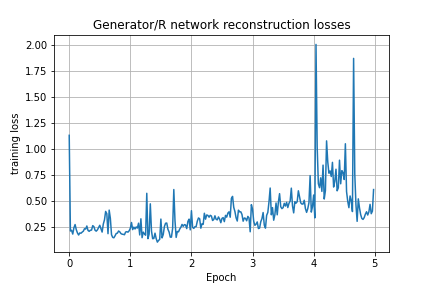

In [ ]:

# This image was generated at the end of the models.py training procedure to help pick a ending epoch to load. 
from IPython.display import Image
Image(filename='plot_g_recon_losses.png')

In [ ]:
# Load the epoch #3 saved weights.
self.adversarial_model.load_weights('./checkpoint/ALOCC_Model_3.h5')

In [ ]:
(X_train, y_train), (_, _) = mnist.load_data()
X_train = X_train / 255

In [ ]:

def test_reconstruction(label, data_index = 11):
    specific_idx = np.where(y_train == label)[0]
    if data_index >= len(X_train):
        data_index = 0
    data = X_train[specific_idx].reshape(-1, 28, 28, 3)[data_index:data_index+1]
    model_predicts = self.adversarial_model.predict(data)
    
    fig= plt.figure(figsize=(8, 8))
    columns = 1
    rows = 2
    fig.add_subplot(rows, columns, 1)
    input_image = data.reshape((28, 28))
    reconstructed_image = model_predicts[0].reshape((28, 28))
    plt.title('Input')
    plt.imshow(input_image, label='Input')
    fig.add_subplot(rows, columns, 2)
    plt.title('Reconstruction')
    plt.imshow(reconstructed_image, label='Reconstructed')
    plt.show()
    # Compute the mean binary_crossentropy loss of reconstructed image.
    y_true = K.variable(reconstructed_image)
    y_pred = K.variable(input_image)
    error = K.eval(binary_crossentropy(y_true, y_pred)).mean()
    print('Reconstruction loss:', error)
    print('Discriminator Output:', model_predicts[1][0][0])

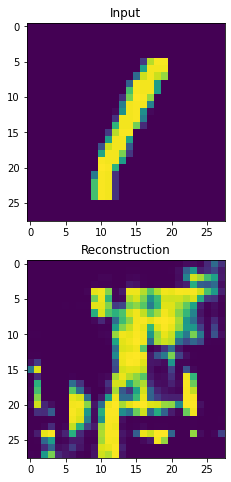

Reconstruction loss: 3.0037143
Discriminator Output: 0.8882415


In [ ]:

test_reconstruction(1)

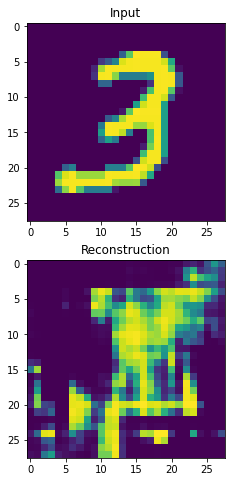

Reconstruction loss: 2.5856671
Discriminator Output: 0.8522202


In [ ]:

test_reconstruction(3)

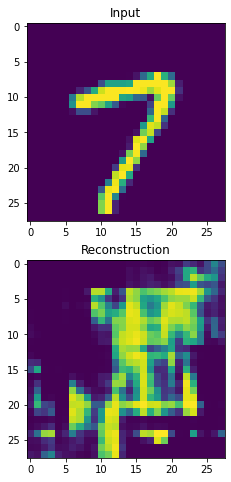

Reconstruction loss: 3.176904
Discriminator Output: 0.8472441


In [ ]:

test_reconstruction(7)